# SegFormer Train

In [1]:
!nvidia-smi

Sat Sep 10 02:44:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%%capture
!pip install wandb --upgrade

In [4]:
!cp /content/drive/MyDrive/Kaggle/netrc ~/.netrc

In [5]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aruaru0. Use `wandb login --relogin` to force relogin


True

## kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/datas/kaggle.json  ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c hubmap-organ-segmentation

100% 5.76G/5.78G [00:43<00:00, 188MB/s]
100% 5.78G/5.78G [00:43<00:00, 142MB/s]


In [9]:
# !mkdir hubmap
!unzip /content/hubmap-organ-segmentation.zip -d hubmap >/dev/null

In [10]:
!pip install pytorch-lightning
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 7.3 MB/s 
     |████████████████████████████████| 419 kB 68.7 MB/s 
     |████████████████████████████████| 5.9 MB 45.2 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.5 MB/s 
     |████████████████████████████████| 365 kB 68.4 MB/s 
     |████████████████████████████████| 

In [11]:
!pip install staintools
!pip install spams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14075 sha256=c4e57586683a0f715fe64dcba6da8ead0bc0cd61e9a5ad34b1c3dc4bd43cb742
  Stored in directory: /root/.cache/pip/wheels/9b/ed/74/9d36d40854e911d8e2d2d28d7b67e37e9f176f913ecf34f813
Successfully built staintools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp37-cp37m-linux_x86_64.whl size=3236589 sha256=57f383ea4ee34562e11abf6cec2745cbfa935bee558fd8e8aee1089efac30b8d
  Stored in directory: /root/.cache/pip/wheels/5e/92/17/e718e0e26bfcdd7e81afcf874ac2bc599dd7dd7f3ad78f9d76
Successfully built spams


In [12]:
# from google.colab import output
# output.enable_custom_widget_manager()

## Start code

In [13]:
import wandb
wandb.init(project="HuBMAP-SegFormer")

In [14]:
%load_ext tensorboard

In [15]:
from google.colab import output
output.enable_custom_widget_manager()

In [16]:
from torch.utils.tensorboard import SummaryWriter

In [17]:
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ConstantLR, LinearLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from timm import create_model

import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import albumentations as albu
import random

import pandas as pd

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

In [18]:
#https://www.kaggle.com/code/pestipeti/decoding-rle-masks/notebook
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle, shape=(3000,3000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

##  load test data

In [19]:
SEED = 2022 #43
BATCH_SIZE = 4
Gradient_Accumulation_Step = 7

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

### FOLD

In [21]:
DATA_DIR = './hubmap'
NFOLD = 5
FOLD = 1

WIDTH, HEIGHT = 512,512

model_path = '/content/drive/MyDrive/datas/HuBMAP/model-b5-fold{}.pth'.format(FOLD)
MODEL_NAME = "nvidia/mit-b5"
# MODEL_NAME = "nvidia/segformer-b3-finetuned-ade-512-512"

wandb.SEED = SEED
wandb.config.NFOLD = NFOLD
wandb.config.FOLD = FOLD
wandb.config.WIDTH = WIDTH
wandb.config.HEIGHT= HEIGHT
wandb.config.MODEL_NAME = MODEL_NAME

#
# nvidia/segformer-b0-finetuned-ade-512-512
# nvidia/segformer-b1-finetuned-ade-512-512
# nvidia/segformer-b2-finetuned-ade-512-512
# nvidia/segformer-b3-finetuned-ade-512-512
# nvidia/segformer-b4-finetuned-ade-512-512
# nvidia/segformer-b5-finetuned-ade-640-640
# https://huggingface.co/models?other=segformer&sort=downloads&search=nvidia%2Fsegformer+finetuned
#
df = pd.read_csv(DATA_DIR + '/train.csv')

In [22]:
# df = df[df['organ']=='lung'].reset_index()
df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [23]:
# class2idx = dict([(name,i+1) for i, name in enumerate(df.organ.unique())])
# class2idx['none'] = 0
# idx2class = dict([(class2idx[name], name) for name in class2idx])

class2idx = {'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0}
idx2class = {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'}

class2idx, idx2class

({'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0},
 {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'})

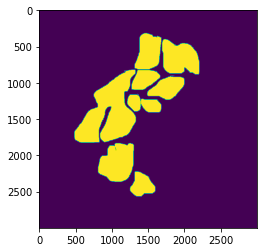

In [24]:
idx = 0
height, width, rle = df['img_height'][idx], df['img_width'][idx], df['rle'][idx]
mask = rle2mask(rle, shape=(height, width))
plt.imshow(mask)

In [25]:
from sklearn.model_selection import StratifiedKFold

df['fold'] = 0

skf = StratifiedKFold(n_splits=5)
for i, index in enumerate(skf.split(df.id, df.organ)):
  train_index, test_index = index
  # print("train_index:", train_index, "test_index:", test_index)
  # df['fold'][test_index] = i
  df.loc[test_index, 'fold'] = i

df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,0
...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,4
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,4
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,4
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,4


## Utils

### augumentation

In [26]:
import staintools

In [27]:
class Stain(albu.ImageOnlyTransform):
    def __init__(
        self,
        method='vahadane', sigma1=0.2, sigma2=0.2,
        always_apply=False,
        p=0.5,
    ):
        super(Stain, self).__init__(always_apply, p)
        self.method = method
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.augmentor = staintools.StainAugmentor(method=method, sigma1=sigma1, sigma2=sigma2)

    def apply(self, img, **params):
        self.augmentor.fit(img)
        return self.augmentor.pop().astype(int)

    def get_params(self):
        return {
        }

    def get_transform_init_args_names(self):
        return ("brightness_limit", "contrast_limit", "brightness_by_max")

In [28]:
# ----- set0
def get_training_augmentation_set0(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
    ], p=p)
# ---- set1
def get_training_augmentation_set1(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        # albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
        #                  border_mode=cv2.BORDER_REFLECT),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.ChannelShuffle(p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
    ], p=p)


In [29]:
def get_training_augmentation3(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            # albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
        # albu.CoarseDropout (max_holes=50, max_height=16, max_width=16, p=p)
    ], p=p)

# def get_training_augmentation3(p=0.5):
#     return albu.Compose([
#         albu.Sequential([
#           albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
#           albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
#         ], p=p),
#         albu.HorizontalFlip(p=p),
#         albu.VerticalFlip(p=p),
#         albu.RandomRotate90(p=p),
#         albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
#                          border_mode=cv2.BORDER_REFLECT),
#         # albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=p, 
#         #                  border_mode=cv2.BORDER_REFLECT),
#         # albu.OneOf([
#         #     albu.OpticalDistortion(p=1),
#         #     albu.GridDistortion(p=1),
#         #     albu.IAAPiecewiseAffine(p=1),
#         # ], p=p),
#         albu.OneOf([
#             albu.ChannelShuffle(p=1),
#             albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
#             albu.CLAHE(clip_limit=2, p = 1),
#             albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
#             albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
#         ], p=p),
#         albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
#         albu.CoarseDropout (max_holes=50, max_height=16, max_width=16, p=p)
#     ], p=p)


In [30]:
def get_training_augmentation2(p=1.0):
    return albu.Compose([
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
        albu.RandomRotate90(),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        albu.OneOf([
            albu.OpticalDistortion(p=0.3),
            albu.GridDistortion(p=.1),
            albu.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        albu.OneOf([
            # albu.HueSaturationValue(10,15,10),
            albu.CLAHE(clip_limit=2),
            albu.RandomBrightnessContrast(),            
        ], p=0.3),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3)
    ], p=p)

def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
        albu.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_grayaug():
    train_transform = [
        albu.ToGray(p=1.0),
    ]
    return albu.Compose(train_transform)

# def get_validation_augmentation():
#     """画像のshapeが32で割り切れるようにPaddingするための関数"""
#     test_transform = [
#         albu.PadIfNeeded(384, 480)
#     ]
#     return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# 可視化用の関数
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## dataset

In [31]:
from transformers import SegformerFeatureExtractor

mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))


# 1. torch.utils.data.Datasetを継承したDataset classを定義
class Dataset(torch.utils.data.Dataset):
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #            'tree', 'signsymbol', 'fence', 'car', 
    #            'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self,
            image_dir, 
            df, # ファイル名一覧
            # classes=None, # 推論対象のクラス
            augmentation=None, # augmentation用関数
            preprocessing=None, # 前処理用関数
            width = 768,
            height = 768,
    ):
        self.image_dir = image_dir
        self.df = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.width = width
        self.height = height
        self.feature_extractor = SegformerFeatureExtractor(MODEL_NAME , reduce_labels=False, size=(width, height))
    
    # 3. 学習用データ(image)と特徴(mask)を返す__getitem__メソッドを作成
    def __getitem__(self, i):
        # データの読み込み
        fname = "{}/{}.tiff".format(self.image_dir,self.df['id'][i])
        # print(fname)
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rle, w, h = self.df['rle'][i], self.df['img_width'][i], self.df['img_height'][i]
        idx = class2idx[self.df['organ'][i]]
        mask = rle2mask(rle, shape = (w, h))
        # print(self.df['organ'][i], idx)

        image = cv2.resize(image, (self.width, self.height))
        mask = cv2.resize(mask, (self.width, self.height)) * idx

        # augmentation関数の適用
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # print("image", image.shape)
        # # return image, mask
        # image = (image/255 - mean)/std
        
        # return img2tensor(image),torch.tensor(mask), idx
        # return image, mask
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

    # 4. データセットの長さを返す__len__を作成
    def __len__(self):
        return len(self.df)

torch.Size([3, 512, 512])


tensor([0, 1])

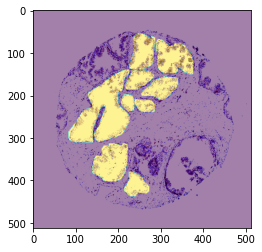

In [32]:
IMAGE_DIR = './hubmap/train_images'
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), width=WIDTH, height=HEIGHT)
input = train_dataset[0]
print(input['pixel_values'].shape)
plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
plt.imshow(input['labels'], alpha=0.5)
input['labels'].unique()

In [33]:
input

{'pixel_values': tensor([[[2.0777, 2.0777, 2.0605,  ..., 2.0777, 2.0777, 2.0777],
         [2.0777, 2.0777, 2.0777,  ..., 2.0777, 2.0777, 2.0777],
         [2.0263, 2.0777, 2.0777,  ..., 2.0777, 2.0777, 2.0777],
         ...,
         [2.0605, 2.0777, 2.0434,  ..., 2.0777, 2.0777, 2.0777],
         [2.0777, 2.0777, 2.0777,  ..., 2.0434, 2.0777, 2.0777],
         [2.0777, 2.0777, 2.0605,  ..., 2.0777, 2.0605, 2.0777]],

        [[2.2360, 2.2535, 2.2185,  ..., 2.2535, 2.2535, 2.2535],
         [2.2360, 2.2360, 2.2535,  ..., 2.2535, 2.2535, 2.2535],
         [2.2010, 2.2185, 2.2535,  ..., 2.2535, 2.2360, 2.2535],
         ...,
         [2.2535, 2.2360, 2.2360,  ..., 2.2535, 2.2535, 2.2535],
         [2.2535, 2.2360, 2.2535,  ..., 2.2535, 2.2360, 2.2535],
         [2.2360, 2.2535, 2.2360,  ..., 2.2360, 2.2360, 2.2535]],

        [[2.4657, 2.4657, 2.4483,  ..., 2.4657, 2.4657, 2.4657],
         [2.4657, 2.4657, 2.4657,  ..., 2.4657, 2.4483, 2.4657],
         [2.3786, 2.3960, 2.4483,  ..., 2

280


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])
0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


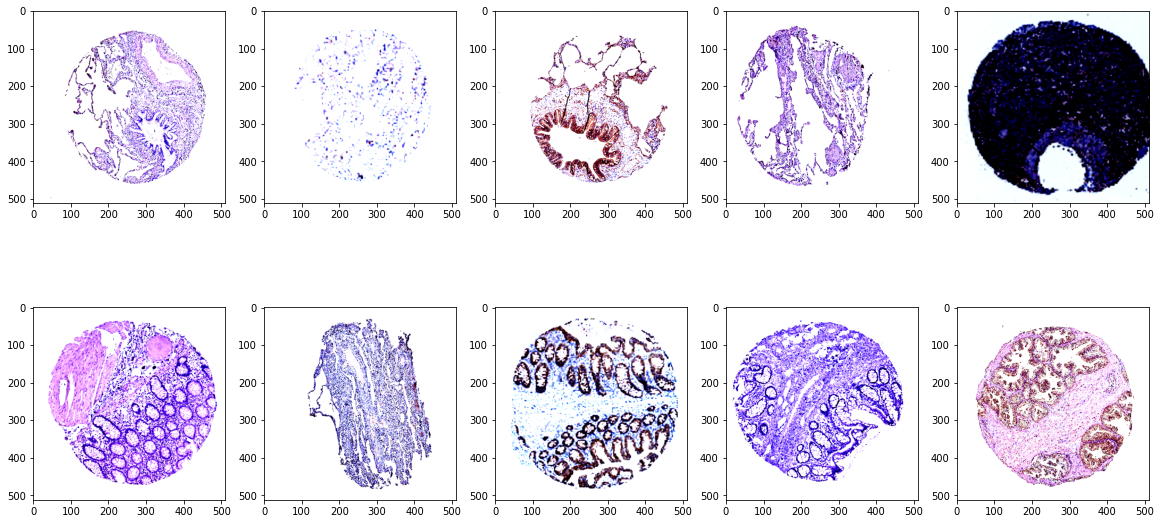

In [34]:
# # # データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != 0].reset_index(), 
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(), 
                        )

plt.figure(figsize=(20, 10))

print(train_dataset.__len__())
for i in range(10) :
  input = train_dataset[i]
  print(idx, input.pixel_values.shape)
  plt.subplot(2, 5, i+1);
  plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
  # plt.imshow(input['labels'], alpha=0.5)
plt.show()

In [35]:
from torch.utils.data import DataLoader
# CLASSES = ['car']


# データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), 
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(p=0.9), 
                        )
# train_dataset = Dataset(IMAGE_DIR, df.reset_index(), 
#                         width=WIDTH, height=HEIGHT,
#                         augmentation=get_training_augmentation3(p=0.9), 
#                         )

valid_dataset = Dataset(
    IMAGE_DIR, df[df['fold'] == FOLD].reset_index(), 
    width=WIDTH, height=HEIGHT,
    augmentation=None, 
)

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

0


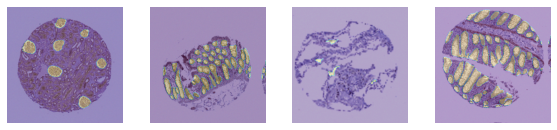

In [36]:
row, col = 8, 8
plt.figure(figsize=(20,20))

for inputs in train_loader:
  print(idx)
  data = inputs['pixel_values']
  mask = inputs['labels']
  for i in range(BATCH_SIZE) :
    plt.subplot(col, row, i+1)
    x = data[i].permute(1,2,0)
    plt.imshow((x-x.min())/(x.max()-x.min()))
    plt.imshow(mask[i], alpha=0.3)
    plt.axis('off')
  # print(data.shape)
  break

## ここまで前処理

In [37]:
from transformers import SegformerForSemanticSegmentation
# define model
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
                                                         num_labels=len(class2idx), 
                                                         id2label=idx2class, 
                                                         label2id=class2idx,
                                                         ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.2

In [38]:
# # model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
# model_path_last = '/content/drive/MyDrive/datas/HuBMAP/last-fold{}.pth'.format(FOLD)
# model_path_last = '/content/drive/MyDrive/datas/HuBMAP/model-b5-fold{}.pth'.format(FOLD)

# model.load_state_dict(torch.load(model_path_last))

In [39]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [40]:
test_df = df[df['fold'] == FOLD].reset_index()

def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice

def valid(model2) :
  model2.eval()
  dice = 0.0
  loss = 0.0
  for i in tqdm(range(len(test_df))) :
    id = test_df.id[i]
    fname = "/content/hubmap/train_images/{}.tiff".format(id)
    image = Image.open(fname)
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.cuda()

    # print(pixel_values.shape)

    organ = test_df.organ[i]
    idx = class2idx[organ]

    rle = test_df.rle[i]
    height, width = test_df.img_height[i], test_df.img_width[i]
    gt = rle2mask(rle, shape = (height, width))
    gt2 = cv2.resize(gt, pixel_values.shape[-2:]) * idx

    label = torch.tensor(gt2).unsqueeze(0).long().cuda()

    # print(label.shape)

    with torch.no_grad():
      outputs = model2(pixel_values=pixel_values, labels=label)
      loss += outputs.loss.item()
      # print(outputs.loss, loss)
      upsampled_logits = nn.functional.interpolate(outputs['logits'],
                  # size=image.size[::-1], # (height, width)
                  (height, width),
                  mode='bilinear',
                  align_corners=False)
      mask = upsampled_logits.argmax(dim=1)[0]
      mask[mask != idx] = 0
      mask[mask == idx] = 1


    dice += dice_coef(mask.cpu().numpy(), gt)
  return dice/len(test_df), loss/len(test_df)

In [41]:
def read_model(file) :
  model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
                                                          num_labels=len(class2idx), 
                                                          id2label=idx2class, 
                                                          label2id=class2idx,
                                                          ignore_mismatched_sizes=True,
  )
  model.load_state_dict(torch.load(file))
  model.cuda()
  model.eval()
  return model

def copy_params(model1, model2) :
  model1.load_state_dict(model2.state_dict())
  return model1

def sum_model_params(modelA, modelB):
    """ modelA + modelB """
    sdA = modelA.state_dict()
    sdB = modelB.state_dict()
    for key in sdA:
        sdA[key] = (sdA[key] + sdB[key])
    modelA.load_state_dict(sdA)
    return modelA

def multi_model_params(model, a):
    """ a * model """
    sd = model.state_dict()
    for key in sd:
        sd[key] = sd[key] * a
    model.load_state_dict(sd)
    return model

In [42]:
# import torch
# from torch import nn
# from sklearn.metrics import accuracy_score
# # from tqdm.notebook import tqdm
# # from tqdm import tqdm
# from fastprogress.fastprogress import  progress_bar as tqdm

# from PIL import Image
# from transformers import SegformerFeatureExtractor

# feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))
# model = model.cuda()
# valid(model)

In [47]:
# model_path_best = "/content/drive/MyDrive/datas/HuBMAP/merge-fold{}.pth".format(FOLD)
# model.load_state_dict(torch.load(model_path_best))

# model.load_state_dict(torch.load("/content/drive/MyDrive/datas/HuBmap-segformer/epoch250-fold1.pth"))

<All keys matched successfully>

In [48]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = copy.deepcopy(model)
best_model.to(device)
best_model.eval()

tmp_model = copy.deepcopy(model).to(device).eval()

## TRAIN


In [49]:
import random

import torch
from torch import nn
from sklearn.metrics import accuracy_score
# from tqdm.notebook import tqdm
# from tqdm import tqdm
from fastprogress.fastprogress import  progress_bar as tqdm

from PIL import Image
from transformers import SegformerFeatureExtractor

writer = SummaryWriter(log_dir="./logs")
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))
use_amp = True # ampをオンオフ


# define optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4,  weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma=0.9)

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
#                                               base_lr=1e-5,
#                                               max_lr=1e-3,
#                                               step_size_up=20,
#                                               step_size_down=30,
#                                               mode="triangular2",
#                                               cycle_momentum=False,
#                                               gamma=0.95)


model.train()
print("best model")
cur_loss,_ = valid(best_model)
print("dice = ", cur_loss)
best_epoch = 0
for epoch in range(400):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   
   model.train()
   optimizer.zero_grad()

   tot_loss = 0.0
   for idx, batch in enumerate(tqdm(train_loader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # print(pixel_values.shape, labels.shape)

        # zero the parameter gradients
        with torch.cuda.amp.autocast(enabled=use_amp):
            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

        tot_loss += loss.detach().cpu().numpy()
        
        scaler.scale(loss).backward()

        if (idx + 1) % Gradient_Accumulation_Step == 0 or idx == len(train_loader) :
            # optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

   scheduler.step()

   print("Loss:", tot_loss/len(train_loader))

   print("valid...")

   dice,valid_loss = valid(model)

   writer.add_scalars("loss", {
       "train": tot_loss/len(train_loader),
       "valid": valid_loss,
       }, epoch+1)  
   writer.add_scalar("lr", scheduler.get_last_lr()[0], epoch+1)
   
   if dice > cur_loss :
     cur_loss = dice
     best_epoch = epoch
     print("update best dice = ", dice, "loss = ", valid_loss)
     torch.save(model.state_dict(), model_path)
     best_model = copy_params(best_model, model)
  #  elif random.random() >= 0.5:
  #    tmp_model = copy_params(tmp_model, best_model)
  #    tmp_model = sum_model_params(tmp_model, model)
  #    tmp_model = multi_model_params(tmp_model, 1/2)
  #    tmp_dice, tmp_valid_loss = valid(tmp_model)
  #    print("dice = ", dice , "tmp = ", tmp_dice, "best = ", cur_loss)
  #    if tmp_dice > cur_loss :
  #       cur_loss = tmp_dice
  #       best_epoch = epoch
  #       model = copy_params(model, tmp_model)
  #       best_model = copy_params(best_model, model)
  #       print("update best dice = ", tmp_dice, "loss = ", tmp_valid_loss, "best <- tmp_model")
  #       torch.save(model.state_dict(), model_path)  
  #    else:
  #      if tmp_dice > dice :
  #        model = copy_params(model, tmp_model)
  #        print("epoch dice = ", tmp_dice, "loss = ", tmp_valid_loss, "model <- tmp_model")
  #      else:
  #        print("epoch dice = ", dice, "loss = ", valid_loss)
   else :
         print("epoch dice = ", dice, "loss = ", valid_loss, "p<0.5")

   if epoch >= 100 and epoch%50 == 0 :
      model_path_last = '/content/drive/MyDrive/datas/HuBmap-segformer/epoch{}-fold{}.pth'.format(epoch, FOLD)
      torch.save(model.state_dict(), model_path_last)
         
   wandb.log({'epoch': epoch, 'train_loss': tot_loss/len(train_loader), "valid_loss": valid_loss, 
              "dice": dice, "lr":scheduler.get_last_lr()[0], "best dice": cur_loss, "best epoch": best_epoch})


writer.close()
wandb.save(model_path)

best model


dice =  0.7822847959009681
Epoch: 251


Loss: 0.043267444038475066
valid...


epoch dice =  0.7697585807366388 loss =  0.0883276459960533 p<0.5
Epoch: 252


Loss: 0.043515984506779154
valid...


epoch dice =  0.776435222433492 loss =  0.08380977507747178 p<0.5
Epoch: 253


Loss: 0.04322348136297414
valid...


epoch dice =  0.7783559471837985 loss =  0.0793844110365691 p<0.5
Epoch: 254


Loss: 0.04276896569169533
valid...


epoch dice =  0.7810426465084751 loss =  0.08682888689051782 p<0.5
Epoch: 255


Loss: 0.04136378037362871
valid...


epoch dice =  0.777019113807534 loss =  0.0842923804019977 p<0.5
Epoch: 256


Loss: 0.040805481938304196
valid...


epoch dice =  0.7762506797137424 loss =  0.08511092881006854 p<0.5
Epoch: 257


Loss: 0.041982034562339246
valid...


epoch dice =  0.7731217686153311 loss =  0.08272463594829398 p<0.5
Epoch: 258


Loss: 0.04318439067197098
valid...


epoch dice =  0.767938958503611 loss =  0.09756492063669221 p<0.5
Epoch: 259


Loss: 0.04322687713560504
valid...


epoch dice =  0.770010681155434 loss =  0.08890107936292355 p<0.5
Epoch: 260


Loss: 0.042912822911961815
valid...


epoch dice =  0.7819799901586865 loss =  0.08611348277689623 p<0.5
Epoch: 261


Loss: 0.0442132817345186
valid...


epoch dice =  0.7673212031980688 loss =  0.08631038755411283 p<0.5
Epoch: 262


Loss: 0.041072802854255894
valid...


epoch dice =  0.779335919397423 loss =  0.08581536500714719 p<0.5
Epoch: 263


Loss: 0.043413737919968616
valid...


epoch dice =  0.7698171625488054 loss =  0.09141764622514269 p<0.5
Epoch: 264


Loss: 0.04476821412083129
valid...


epoch dice =  0.7791640785945537 loss =  0.08157224768573153 p<0.5
Epoch: 265


Loss: 0.04796451458733686
valid...


epoch dice =  0.7712912185684481 loss =  0.08538129076561225 p<0.5
Epoch: 266


Loss: 0.0448888433690537
valid...


epoch dice =  0.7789370185931707 loss =  0.08659510612820408 p<0.5
Epoch: 267


Loss: 0.04355685403701705
valid...


epoch dice =  0.7746426197462538 loss =  0.09437011201599879 p<0.5
Epoch: 268


Loss: 0.042816072886048905
valid...


epoch dice =  0.778374661148199 loss =  0.08733878080467028 p<0.5
Epoch: 269


Loss: 0.04252496687039523
valid...


epoch dice =  0.7715025840115202 loss =  0.08812850699760019 p<0.5
Epoch: 270


Loss: 0.0422297966745223
valid...


epoch dice =  0.7781108590396637 loss =  0.08720940266669329 p<0.5
Epoch: 271


Loss: 0.04327878426812904
valid...


epoch dice =  0.775248040361574 loss =  0.08546352027250188 p<0.5
Epoch: 272


Loss: 0.0427059899740131
valid...


epoch dice =  0.7712028901026561 loss =  0.08168610573380387 p<0.5
Epoch: 273


Loss: 0.04242585001277252
valid...


epoch dice =  0.77870100145793 loss =  0.09186561779850828 p<0.5
Epoch: 274


Loss: 0.044446758886563104
valid...


epoch dice =  0.7783228384983867 loss =  0.08705243810545653 p<0.5
Epoch: 275


Loss: 0.0412335126647647
valid...


epoch dice =  0.7737809815211404 loss =  0.08846887131221592 p<0.5
Epoch: 276


Loss: 0.038116000684529125
valid...


epoch dice =  0.7736359659365638 loss =  0.09066093338686707 p<0.5
Epoch: 277


Loss: 0.04221439273686896
valid...


epoch dice =  0.7758592402925218 loss =  0.08797254069941118 p<0.5
Epoch: 278


Loss: 0.04060843969944497
valid...


epoch dice =  0.7761599710181898 loss =  0.09143400355242193 p<0.5
Epoch: 279


Loss: 0.03872327241574375
valid...


epoch dice =  0.7786362767077263 loss =  0.08858969356598599 p<0.5
Epoch: 280


Loss: 0.04188487391499147
valid...


epoch dice =  0.7757776998228996 loss =  0.0941300098218822 p<0.5
Epoch: 281


Loss: 0.042856820321208994
valid...


epoch dice =  0.7767143501796618 loss =  0.09010651926510035 p<0.5
Epoch: 282


Loss: 0.038460837585300625
valid...


epoch dice =  0.7720908381514626 loss =  0.09609777897795928 p<0.5
Epoch: 283


Loss: 0.039220861480636915
valid...


epoch dice =  0.7818612849860007 loss =  0.08677289846153664 p<0.5
Epoch: 284


Loss: 0.04176974312310487
valid...


epoch dice =  0.7739453180729109 loss =  0.09106368721861924 p<0.5
Epoch: 285


Loss: 0.03894338531183525
valid...


epoch dice =  0.7813754346499469 loss =  0.08732104115188122 p<0.5
Epoch: 286


Loss: 0.039884495063566824
valid...


epoch dice =  0.778635087986834 loss =  0.09196605228020677 p<0.5
Epoch: 287


Loss: 0.037802778918978194
valid...


epoch dice =  0.7767102638283837 loss =  0.08772380123846232 p<0.5
Epoch: 288


Loss: 0.04129855136688746
valid...


epoch dice =  0.77333751627518 loss =  0.09414800617045589 p<0.5
Epoch: 289


Loss: 0.040845158181979625
valid...


epoch dice =  0.7660717390829433 loss =  0.08919410321063229 p<0.5
Epoch: 290


Loss: 0.03978875639494246
valid...


epoch dice =  0.7762197592288526 loss =  0.09195833319598543 p<0.5
Epoch: 291


Loss: 0.04385255065969598
valid...


epoch dice =  0.7757323771980864 loss =  0.09337604106403888 p<0.5
Epoch: 292


Loss: 0.039598299662621926
valid...


epoch dice =  0.775852397182487 loss =  0.09282556441612541 p<0.5
Epoch: 293


Loss: 0.04035084302419088
valid...


epoch dice =  0.7792957550725551 loss =  0.09287123519461601 p<0.5
Epoch: 294


Loss: 0.04121594403831052
valid...


epoch dice =  0.7733393269616039 loss =  0.09810585664984371 p<0.5
Epoch: 295


Loss: 0.041174562267539364
valid...


epoch dice =  0.771788853199132 loss =  0.09328993338692401 p<0.5
Epoch: 296


Loss: 0.03947708615377336
valid...


epoch dice =  0.7803139182546018 loss =  0.09143285020254552 p<0.5
Epoch: 297


Loss: 0.040887854534240674
valid...


epoch dice =  0.7780890418393553 loss =  0.08968133376911283 p<0.5
Epoch: 298


Loss: 0.04265712789246734
valid...


epoch dice =  0.7638587390188862 loss =  0.09024495101600354 p<0.5
Epoch: 299


Loss: 0.04628392779858599
valid...


epoch dice =  0.7590218341886753 loss =  0.09337047539385301 p<0.5
Epoch: 300


Loss: 0.04145704337041563
valid...


epoch dice =  0.7728163696192796 loss =  0.08611605713210468 p<0.5
Epoch: 301


Loss: 0.04227203150397875
valid...


epoch dice =  0.7637152974322221 loss =  0.08830619367571281 p<0.5
Epoch: 302


Loss: 0.04702475369238938
valid...


epoch dice =  0.7535514728959352 loss =  0.10529751778314156 p<0.5
Epoch: 303


Loss: 0.04807372778181879
valid...


epoch dice =  0.7555004228712765 loss =  0.08877999620911266 p<0.5
Epoch: 304


Loss: 0.047095188267633946
valid...


epoch dice =  0.7661497911708569 loss =  0.09591732234361448 p<0.5
Epoch: 305


Loss: 0.04333197476316086
valid...


epoch dice =  0.7630886074812601 loss =  0.10296720006569687 p<0.5
Epoch: 306


Loss: 0.04137925151735544
valid...


epoch dice =  0.7738720510926858 loss =  0.08944214048263217 p<0.5
Epoch: 307


Loss: 0.041095801183140615
valid...


epoch dice =  0.7745952581342015 loss =  0.0890843998407945 p<0.5
Epoch: 308


Loss: 0.04107746278578547
valid...


epoch dice =  0.7703300784545174 loss =  0.0890080837665924 p<0.5
Epoch: 309


Loss: 0.040823805473849804
valid...


epoch dice =  0.7699185041365206 loss =  0.09377442788931407 p<0.5
Epoch: 310


Loss: 0.03987573195432483
valid...


epoch dice =  0.777300981843047 loss =  0.09296820887830108 p<0.5
Epoch: 311


Loss: 0.039231168381659916
valid...


epoch dice =  0.7709750090183901 loss =  0.09010606913361699 p<0.5
Epoch: 312


Loss: 0.03826785292214071
valid...


epoch dice =  0.7745096446234591 loss =  0.09058156992042703 p<0.5
Epoch: 313


Loss: 0.03945059669007298
valid...


epoch dice =  0.7771528747583163 loss =  0.09455817069060037 p<0.5
Epoch: 314


Loss: 0.03735232303365016
valid...


epoch dice =  0.7788176986926416 loss =  0.09041982296122504 p<0.5
Epoch: 315


Loss: 0.03862612967340039
valid...


epoch dice =  0.781538429752894 loss =  0.08926910369856549 p<0.5
Epoch: 316


Loss: 0.036742752142460415
valid...


update best dice =  0.7849829332262694 loss =  0.08911304624219026
Epoch: 317


Loss: 0.03743934061404475
valid...


epoch dice =  0.7803562159268574 loss =  0.09008961689458894 p<0.5
Epoch: 318


Loss: 0.038013154562090486
valid...


epoch dice =  0.7762705861035146 loss =  0.09164539914511677 p<0.5
Epoch: 319


Loss: 0.038069064059937506
valid...


epoch dice =  0.777187534131778 loss =  0.08775266566579895 p<0.5
Epoch: 320


Loss: 0.0364151798765844
valid...


epoch dice =  0.7835657254066412 loss =  0.08977067018193859 p<0.5
Epoch: 321


Loss: 0.03909499270343025
valid...


epoch dice =  0.7785790417861191 loss =  0.09111227695497551 p<0.5
Epoch: 322


Loss: 0.03915302321629625
valid...


epoch dice =  0.7713853718902003 loss =  0.09272553102512444 p<0.5
Epoch: 323


Loss: 0.039214717525936346
valid...


epoch dice =  0.7708686198933048 loss =  0.097327595468544 p<0.5
Epoch: 324


Loss: 0.03727920298976168
valid...


epoch dice =  0.7780357776425857 loss =  0.0947944934080754 p<0.5
Epoch: 325


Loss: 0.037128996438491095
valid...


epoch dice =  0.7768285894861356 loss =  0.09664827766495623 p<0.5
Epoch: 326


Loss: 0.03477873952246048
valid...


epoch dice =  0.7773188429308259 loss =  0.09293509168117972 p<0.5
Epoch: 327


Loss: 0.037817971964537254
valid...


epoch dice =  0.7767101403125003 loss =  0.09039600066108895 p<0.5
Epoch: 328


Loss: 0.0395755020796623
valid...


epoch dice =  0.7819142992281455 loss =  0.0934729868280036 p<0.5
Epoch: 329


Loss: 0.03611693867075611
valid...


epoch dice =  0.7810613799438995 loss =  0.09558197583038626 p<0.5
Epoch: 330


Loss: 0.0354402085871134
valid...


epoch dice =  0.7808786284510512 loss =  0.09189301240257919 p<0.5
Epoch: 331


Loss: 0.03545446814575665
valid...


epoch dice =  0.7815515430060176 loss =  0.09140545698880617 p<0.5
Epoch: 332


Loss: 0.03588016158704397
valid...


epoch dice =  0.7808904314331739 loss =  0.09428673286456615 p<0.5
Epoch: 333


Loss: 0.03788928322913781
valid...


epoch dice =  0.7787113269158155 loss =  0.09191308292959417 p<0.5
Epoch: 334


Loss: 0.03472139706677744
valid...


epoch dice =  0.783424636140838 loss =  0.09103459080215544 p<0.5
Epoch: 335


Loss: 0.03825917695714554
valid...


epoch dice =  0.7819982452680021 loss =  0.0925271652173251 p<0.5
Epoch: 336


Loss: 0.03585953370366298
valid...


epoch dice =  0.7772828973382302 loss =  0.09811294421919488 p<0.5
Epoch: 337


Loss: 0.035271942943439515
valid...


epoch dice =  0.7800236042249835 loss =  0.0927993607407968 p<0.5
Epoch: 338


Loss: 0.03667303265242929
valid...


epoch dice =  0.7780260063590141 loss =  0.09318067241526608 p<0.5
Epoch: 339


Loss: 0.0360075915363473
valid...


epoch dice =  0.7834456991370538 loss =  0.0917987215465733 p<0.5
Epoch: 340


Loss: 0.03668004219275965
valid...


epoch dice =  0.7827733806473787 loss =  0.09460499038520669 p<0.5
Epoch: 341


Loss: 0.036262971742577116
valid...


epoch dice =  0.7747667472210231 loss =  0.0977363298214706 p<0.5
Epoch: 342


Loss: 0.03598288264335461
valid...


epoch dice =  0.778097229419964 loss =  0.09607451374509506 p<0.5
Epoch: 343


Loss: 0.03570860654482959
valid...


epoch dice =  0.7830851684779387 loss =  0.09214516887773892 p<0.5
Epoch: 344


Loss: 0.035166853573173285
valid...


epoch dice =  0.7761121777577724 loss =  0.09597957871987352 p<0.5
Epoch: 345


Loss: 0.034498706656757375
valid...


epoch dice =  0.7793617674256242 loss =  0.09405196666318391 p<0.5
Epoch: 346


Loss: 0.03727750906812578
valid...


epoch dice =  0.7749972908410595 loss =  0.09405372089573315 p<0.5
Epoch: 347


Loss: 0.03479909957845656
valid...


epoch dice =  0.7746335113173917 loss =  0.09792366656142154 p<0.5
Epoch: 348


Loss: 0.034378814589704425
valid...


epoch dice =  0.7758255439590038 loss =  0.09447848408349922 p<0.5
Epoch: 349


Loss: 0.03617840912520991
valid...


epoch dice =  0.7746041557577792 loss =  0.09302358132055295 p<0.5
Epoch: 350


Loss: 0.03588388087621457
valid...


epoch dice =  0.7813074090226704 loss =  0.09363531197886914 p<0.5
Epoch: 351


Loss: 0.03752914353103285
valid...


epoch dice =  0.7782126495193664 loss =  0.09249276261710163 p<0.5
Epoch: 352


Loss: 0.034840249718809634
valid...


epoch dice =  0.7769399202156291 loss =  0.09749995211604982 p<0.5
Epoch: 353


Loss: 0.03682559464966327
valid...


epoch dice =  0.7759059902983217 loss =  0.1036957718332165 p<0.5
Epoch: 354


Loss: 0.033297670152510554
valid...


epoch dice =  0.7792909934681288 loss =  0.10007681160100869 p<0.5
Epoch: 355


Loss: 0.0346357380761437
valid...


epoch dice =  0.7824372536069801 loss =  0.09823860188480467 p<0.5
Epoch: 356


Loss: 0.0330992201474351
valid...


epoch dice =  0.7805273270445636 loss =  0.09588895425133939 p<0.5
Epoch: 357


Loss: 0.03535907226286723
valid...


epoch dice =  0.7816389716095621 loss =  0.09545987495886428 p<0.5
Epoch: 358


Loss: 0.0351131811187091
valid...


epoch dice =  0.7790423735784943 loss =  0.09263809069858066 p<0.5
Epoch: 359


Loss: 0.03543854885223046
valid...


update best dice =  0.7853083035941699 loss =  0.09129372333242958
Epoch: 360


Loss: 0.03496486351261256
valid...


epoch dice =  0.7808131330163509 loss =  0.09376990650447883 p<0.5
Epoch: 361


Loss: 0.03377001076726846
valid...


epoch dice =  0.7781315237773225 loss =  0.09822065814930414 p<0.5
Epoch: 362


Loss: 0.03344957516725424
valid...


epoch dice =  0.78099777738045 loss =  0.0954514530188005 p<0.5
Epoch: 363


Loss: 0.033657029481001306
valid...


epoch dice =  0.7792317861750911 loss =  0.09541485605628362 p<0.5
Epoch: 364


Loss: 0.03523010915328919
valid...


epoch dice =  0.7773849326365936 loss =  0.09225512001596924 p<0.5
Epoch: 365


Loss: 0.035879928284180414
valid...


epoch dice =  0.7770965702660431 loss =  0.0968647616483005 p<0.5
Epoch: 366


Loss: 0.03412445159760159
valid...


epoch dice =  0.7783604390663907 loss =  0.09913146184823875 p<0.5
Epoch: 367


Loss: 0.03484730844871259
valid...


epoch dice =  0.7777045511004035 loss =  0.09962522839861257 p<0.5
Epoch: 368


Loss: 0.03502598065804218
valid...


epoch dice =  0.7782033427474426 loss =  0.09742683673809682 p<0.5
Epoch: 369


Loss: 0.03366407349994275
valid...


epoch dice =  0.7826052249503225 loss =  0.09525867187684135 p<0.5
Epoch: 370


Loss: 0.03515379613553974
valid...


epoch dice =  0.7790851076271306 loss =  0.09486606625307883 p<0.5
Epoch: 371


Loss: 0.03414645502474946
valid...


epoch dice =  0.7803674243484576 loss =  0.09488364243214684 p<0.5
Epoch: 372


Loss: 0.03355027640789327
valid...


epoch dice =  0.7824321506371211 loss =  0.09633234007217523 p<0.5
Epoch: 373


Loss: 0.03576788823710571
valid...


epoch dice =  0.7758375589980364 loss =  0.09736863236508465 p<0.5
Epoch: 374


Loss: 0.034688379543400566
valid...


epoch dice =  0.7731715796386353 loss =  0.09535101211762854 p<0.5
Epoch: 375


Loss: 0.037420402510537645
valid...


epoch dice =  0.772704257788378 loss =  0.09746736077192639 p<0.5
Epoch: 376


Loss: 0.035082932646897894
valid...


epoch dice =  0.7732474653654441 loss =  0.091850088879333 p<0.5
Epoch: 377


Loss: 0.03534163210645948
valid...


epoch dice =  0.7706628257867892 loss =  0.09522043625225446 p<0.5
Epoch: 378


Loss: 0.03497337825386457
valid...


epoch dice =  0.7722752408800516 loss =  0.09741043304425798 p<0.5
Epoch: 379


Loss: 0.03330913615662237
valid...


epoch dice =  0.774920545921597 loss =  0.0986936492013878 p<0.5
Epoch: 380


Loss: 0.03422515339572245
valid...


epoch dice =  0.7721652858022803 loss =  0.09570262630004436 p<0.5
Epoch: 381


Loss: 0.03561481112666743
valid...


epoch dice =  0.7752957137170112 loss =  0.09599745231680572 p<0.5
Epoch: 382


Loss: 0.034621974728791645
valid...


epoch dice =  0.7753375009997978 loss =  0.09389744247975094 p<0.5
Epoch: 383


Loss: 0.03479452362992394
valid...


epoch dice =  0.7707626521596898 loss =  0.10086812008438366 p<0.5
Epoch: 384


Loss: 0.03652730093560588
valid...


epoch dice =  0.7814322987570687 loss =  0.10014113236019122 p<0.5
Epoch: 385


Loss: 0.0349455655381923
valid...


epoch dice =  0.7800320596127676 loss =  0.09604617576114834 p<0.5
Epoch: 386


Loss: 0.033932972476411034
valid...


epoch dice =  0.7809210910868593 loss =  0.09951736830574061 p<0.5
Epoch: 387


Loss: 0.03523461493125684
valid...


epoch dice =  0.7795839043711833 loss =  0.09389236421390836 p<0.5
Epoch: 388


Loss: 0.03346216470055597
valid...


epoch dice =  0.7767404472366876 loss =  0.10319455491179334 p<0.5
Epoch: 389


Loss: 0.03357027685532058
valid...


epoch dice =  0.7748144317224315 loss =  0.10213780952617527 p<0.5
Epoch: 390


Loss: 0.0336878593932365
valid...


epoch dice =  0.772231146721156 loss =  0.09912245897576213 p<0.5
Epoch: 391


Loss: 0.03412184968564502
valid...


epoch dice =  0.7802724607443978 loss =  0.09788938633033208 p<0.5
Epoch: 392


Loss: 0.032064083347123275
valid...


epoch dice =  0.7791640045475825 loss =  0.09799931112211198 p<0.5
Epoch: 393


Loss: 0.034528200855662286
valid...


epoch dice =  0.776694593516531 loss =  0.09853340269598578 p<0.5
Epoch: 394


Loss: 0.03398368143620835
valid...


epoch dice =  0.7751523772773943 loss =  0.10062814043568713 p<0.5
Epoch: 395


Loss: 0.034746040255618345
valid...


epoch dice =  0.7768714607196604 loss =  0.1030135744517403 p<0.5
Epoch: 396


Loss: 0.033378408920072336
valid...


epoch dice =  0.7782019243069138 loss =  0.09625265977811068 p<0.5
Epoch: 397


Loss: 0.035011027519866615
valid...


epoch dice =  0.7774073462570836 loss =  0.09839059927035124 p<0.5
Epoch: 398


Loss: 0.033800609580332965
valid...


epoch dice =  0.7729656203843952 loss =  0.0998653869942895 p<0.5
Epoch: 399


Loss: 0.03349910835197694
valid...


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


epoch dice =  0.772804578969304 loss =  0.10188178199210338 p<0.5


['/content/wandb/run-20220910_024854-392ycsoi/files/model-b5-fold1.pth']

In [50]:
model_path_last = '/content/drive/MyDrive/datas/HuBMAP/last-fold{}.pth'.format(FOLD)
torch.save(model.state_dict(), model_path_last)
wandb.save(model_path_last)

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/content/wandb/run-20220910_024854-392ycsoi/files/last-fold1.pth']

In [ ]:
%tensorboard --logdir ./logs

In [ ]:
# from transformers import SegformerForSemanticSegmentation
# # define model
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
#                                                          num_labels=len(class2idx), 
#                                                          id2label=idx2class, 
#                                                          label2id=class2idx,
# )

In [ ]:
# model2 = SegformerForSemanticSegmentation(model.config)
# model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
# model2.load_state_dict(torch.load(model_path))
# model2 = model2.cuda()

In [ ]:
# from PIL import Image
# image = Image.open('/content/hubmap/train_images/10044.tiff')
# plt.imshow(image)

In [ ]:
# from transformers import SegformerFeatureExtractor
# feature_extractor = SegformerFeatureExtractor(reduce_labels=False)

# encoding = feature_extractor(image, return_tensors="pt")
# pixel_values = encoding.pixel_values.cuda()
# print(pixel_values.shape)

In [ ]:
# # forward pass
# outputs = model2(pixel_values=pixel_values)

In [ ]:
# logits = outputs.logits.cpu()
# print(logits.shape)

In [ ]:
# def ade_palette():
#     """ADE20K palette that maps each class to RGB values."""
#     return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
#             [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255]]

In [ ]:
# from torch import nn
# import numpy as np
# import matplotlib.pyplot as plt

# # First, rescale logits to original image size
# upsampled_logits = nn.functional.interpolate(logits,
#                 size=image.size[::-1], # (height, width)
#                 mode='bilinear',
#                 align_corners=False)

# # Second, apply argmax on the class dimension
# seg = upsampled_logits.argmax(dim=1)[0]
# color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
# palette = np.array(ade_palette())
# for label, color in enumerate(palette):
#     color_seg[seg == label, :] = color
# # Convert to BGR
# color_seg = color_seg[..., ::-1]

# # Show image + mask
# img = np.array(image) * 0.5 + color_seg * 0.5
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

# inference

In [ ]:
def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice


In [ ]:
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerModel, SegformerConfig

# define model
# model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
#                                                          num_labels=len(class2idx), 
#                                                          id2label=idx2class, 
#                                                          label2id=class2idx,
# )


config = SegformerConfig.from_pretrained(MODEL_NAME,
                        num_labels=len(class2idx), 
                        id2label=idx2class, 
                        label2id=class2idx,
                        ignore_mismatched_sizes=True,
)

model2 = SegformerForSemanticSegmentation(config)
# model_path = '/content/drive/MyDrive/datas/HuBMAP/model-sub3-fold{}.pth'.format(FOLD)
model2.load_state_dict(torch.load(model_path))
model2 = model2.cuda()

In [ ]:
from PIL import Image
from transformers import SegformerFeatureExtractor
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))

# print(pixel_values.shape)
# image = Image.open('/content/hubmap/train_images/10651.tiff')
# plt.imshow(image)

model2.eval()
dice = 0.0

test_df = df[df['fold'] == FOLD].reset_index()
for i in range(len(test_df)) :
  id = test_df.id[i]
  fname = "/content/hubmap/train_images/{}.tiff".format(id)
  image = Image.open(fname)
  encoding = feature_extractor(image, return_tensors="pt")
  pixel_values = encoding.pixel_values.cuda()
  organ = test_df.organ[i]
  rle = test_df.rle[i]
  height, width = test_df.img_height[i], test_df.img_width[i]
  idx = class2idx[organ]
  with torch.no_grad():
    outputs = model2(pixel_values=pixel_values)
    upsampled_logits = nn.functional.interpolate(outputs['logits'],
                # size=image.size[::-1], # (height, width)
                (height, width),
                mode='bilinear',
                align_corners=False)
    mask = upsampled_logits.argmax(dim=1)[0]
    mask[mask != idx] = 0
    mask[mask == idx] = 1

  gt = rle2mask(rle, shape = (height, width))
  plt.figure(figsize=(10,10))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.imshow(mask.cpu().numpy(), alpha=0.3)
  plt.title("{}-{}-{},{}".format(id, organ, width, height))
  plt.subplot(1, 2, 2)
  plt.imshow(image)
  plt.imshow(gt, alpha=0.3)
  plt.show()

  dice += dice_coef(mask.cpu().numpy(), gt)
  print(dice_coef(mask.cpu().numpy(), gt), dice/(i+1))

print("DICE = ", dice/len(test_df))

In [ ]:
len(test_df)

In [ ]:
def calc_resize(w, p) :
    a = 3000/512
    target = int((w*p/0.4)/a + 0.5)
    target = (target+31)//32 * 32
    return target

calc_resize(2023, 0.4945), calc_resize(3000, 0.4), calc_resize(160, 6.263), calc_resize(4500, 0.2290)

In [ ]:
!pip install staintools
!pip install spams

In [ ]:
# 多くのカグラーは染色ツールを使用して、増強のために組織画像の色を着色しています。
# 彼らは他のより重要な側面を見逃しています：テクスチャ（すなわち形態）
import staintools

# Read data
to_augment = staintools.read_image("/content/hubmap/train_images/10044.tiff")

# Standardize brightness (optional, can improve the tissue mask calculation)
# to_augment = staintools.LuminosityStandardizer.standardize(to_augment)

# Stain augment
augmentor = staintools.StainAugmentor(method='vahadane', sigma1=0.2, sigma2=0.2)

augmentor.fit(to_augment)
augmented_images = []
for _ in range(2):
    augmented_image = augmentor.pop()
    augmented_images.append(augmented_image)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(to_augment)
plt.show()
for e in augmented_images:
  plt.imshow(e/255)
  plt.show()